<a href="https://colab.research.google.com/github/Massizelle/TP-analyse-d-images/blob/main/transformations_geometriques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformations Géométriques

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

plt.rcParams['figure.figsize'] = (15, 5)
%matplotlib inline

## Chargement de l'image test

Image chargée: data/cameraman.png


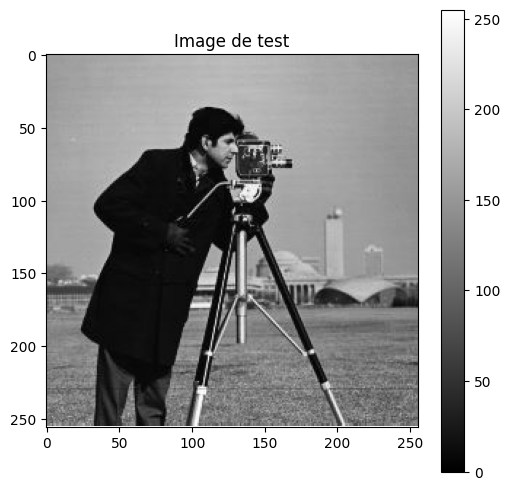

In [33]:
os.makedirs('data', exist_ok=True)

def load_test_image():
    cameraman_path = 'data/cameraman.png'

    if os.path.exists(cameraman_path):
        img = np.array(Image.open(cameraman_path).convert('L'))
        print(f"Image chargée: {cameraman_path}")
    else:
        # Créer une image de test si le cameraman n'est pas disponible
        print("Image cameraman non trouvée. Création d'une image de test...")
        img = np.zeros((256, 256), dtype=np.uint8)
        for i in range(0, 256, 32):
            img[i:i+16, :] = 255
            img[:, i:i+16] = 255
        y, x = np.ogrid[:256, :256]
        mask = (x - 128)**2 + (y - 128)**2 <= 50**2
        img[mask] = 200

    return img.astype(np.float64)

# Charger l'image
image_test = load_test_image()

# Afficher l'image
plt.figure(figsize=(6, 6))
plt.imshow(image_test, cmap='gray')
plt.title('Image de test')
plt.colorbar()
plt.show()

## Exercice 1 : Transposée d'une image

La transposée d'une image consiste à échanger les coordonnées x et y:
$$g((x, y)) = f((y, x))$$

In [34]:
def transpose(image):
    height, width = image.shape
    result = np.zeros((width, height), dtype=image.dtype)

    for y in range(height):
        for x in range(width):
            result[x, y] = image[y, x]

    return result

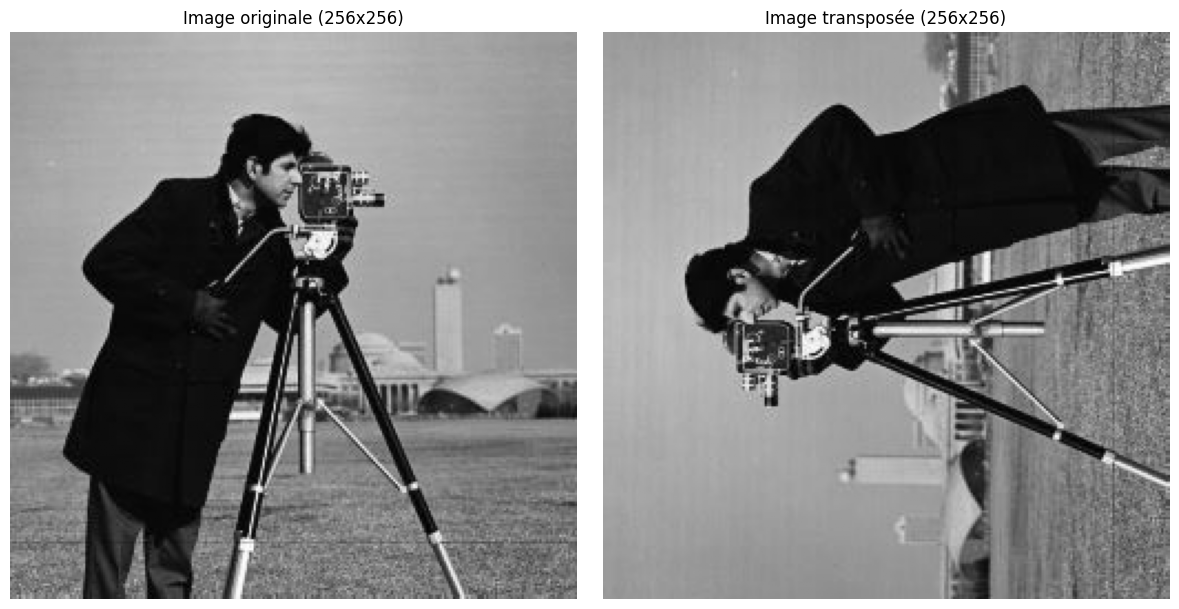

In [35]:
# Test de la transposée
image_transposed = transpose(image_test)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image_test, cmap='gray')
axes[0].set_title(f'Image originale ({image_test.shape[0]}x{image_test.shape[1]})')
axes[0].axis('off')

axes[1].imshow(image_transposed, cmap='gray')
axes[1].set_title(f'Image transposée ({image_transposed.shape[0]}x{image_transposed.shape[1]})')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## Exercice 2 : Interpolation par plus proche voisin

L'interpolation par plus proche voisin attribue à un point de coordonnées réelles la valeur du pixel entier le plus proche:
$$F(x, y) = f(\lfloor x + 0.5 \rfloor, \lfloor y + 0.5 \rfloor)$$

In [36]:
def interpolate_nearest(image, x, y):

    height, width = image.shape

    # Arrondir aux coordonnées entières les plus proches
    x_int = int(np.floor(x + 0.5))
    y_int = int(np.floor(y + 0.5))

    # Vérifier les limites
    if x_int < 0 or x_int >= width or y_int < 0 or y_int >= height:
        return 0.0

    return image[y_int, x_int]


def expand(image, factor, interpolation_func):
    height, width = image.shape
    new_height = int(height * factor)
    new_width = int(width * factor)

    result = np.zeros((new_height, new_width), dtype=image.dtype)

    for y_new in range(new_height):
        for x_new in range(new_width):
            # Coordonnées dans l'image source
            x_old = x_new / factor
            y_old = y_new / factor

            # Interpoler la valeur
            result[y_new, x_new] = interpolation_func(image, x_old, y_old)

    return result

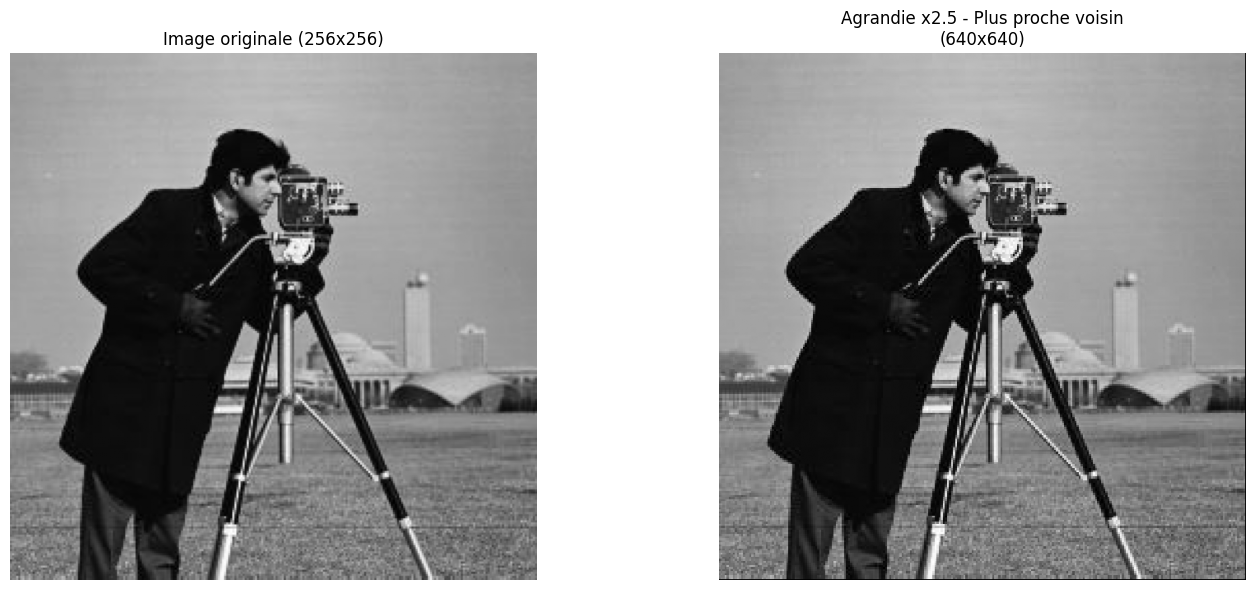

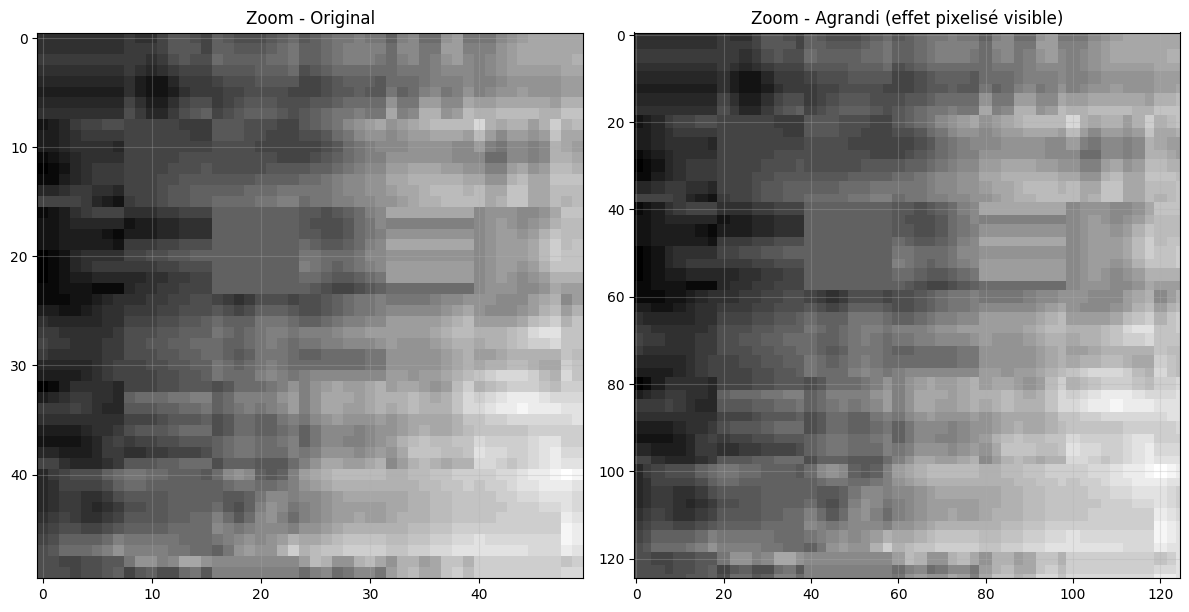

In [37]:
# Test de l'agrandissement avec interpolation plus proche voisin
factor = 2.5
image_expanded_nearest = expand(image_test, factor, interpolate_nearest)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].imshow(image_test, cmap='gray')
axes[0].set_title(f'Image originale ({image_test.shape[0]}x{image_test.shape[1]})')
axes[0].axis('off')

axes[1].imshow(image_expanded_nearest, cmap='gray')
axes[1].set_title(f'Agrandie x{factor} - Plus proche voisin\n({image_expanded_nearest.shape[0]}x{image_expanded_nearest.shape[1]})')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Zoom sur une petite zone pour voir l'effet
zoom_size = 50
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(image_test[:zoom_size, :zoom_size], cmap='gray', interpolation='nearest')
axes[0].set_title('Zoom - Original')
axes[0].grid(True, alpha=0.3)

zoom_new = int(zoom_size * factor)
axes[1].imshow(image_expanded_nearest[:zoom_new, :zoom_new], cmap='gray', interpolation='nearest')
axes[1].set_title('Zoom - Agrandi (effet pixelisé visible)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Exercice 3 : Interpolation bilinéaire

L'interpolation bilinéaire utilise les 4 pixels voisins

In [38]:
def interpolate_bilinear(image, x, y):

    height, width = image.shape

    # Coordonnées des 4 points voisins
    x1 = int(np.floor(x))
    y1 = int(np.floor(y))
    x2 = x1 + 1
    y2 = y1 + 1

    # Vérifier les limites
    if x1 < 0 or x2 >= width or y1 < 0 or y2 >= height:
        # Si on est hors limites, utiliser l'interpolation plus proche voisin
        return interpolate_nearest(image, x, y)

    # Calculer alpha et beta
    alpha = x - x1  # proportion de x2
    beta = y - y1   # proportion de y2

    # Valeurs aux 4 coins
    f11 = image[y1, x1]
    f21 = image[y1, x2]
    f12 = image[y2, x1]
    f22 = image[y2, x2]

    # Interpolation bilinéaire
    result = (1 - alpha) * (1 - beta) * f11 + \
             alpha * (1 - beta) * f21 + \
             (1 - alpha) * beta * f12 + \
             alpha * beta * f22

    return result

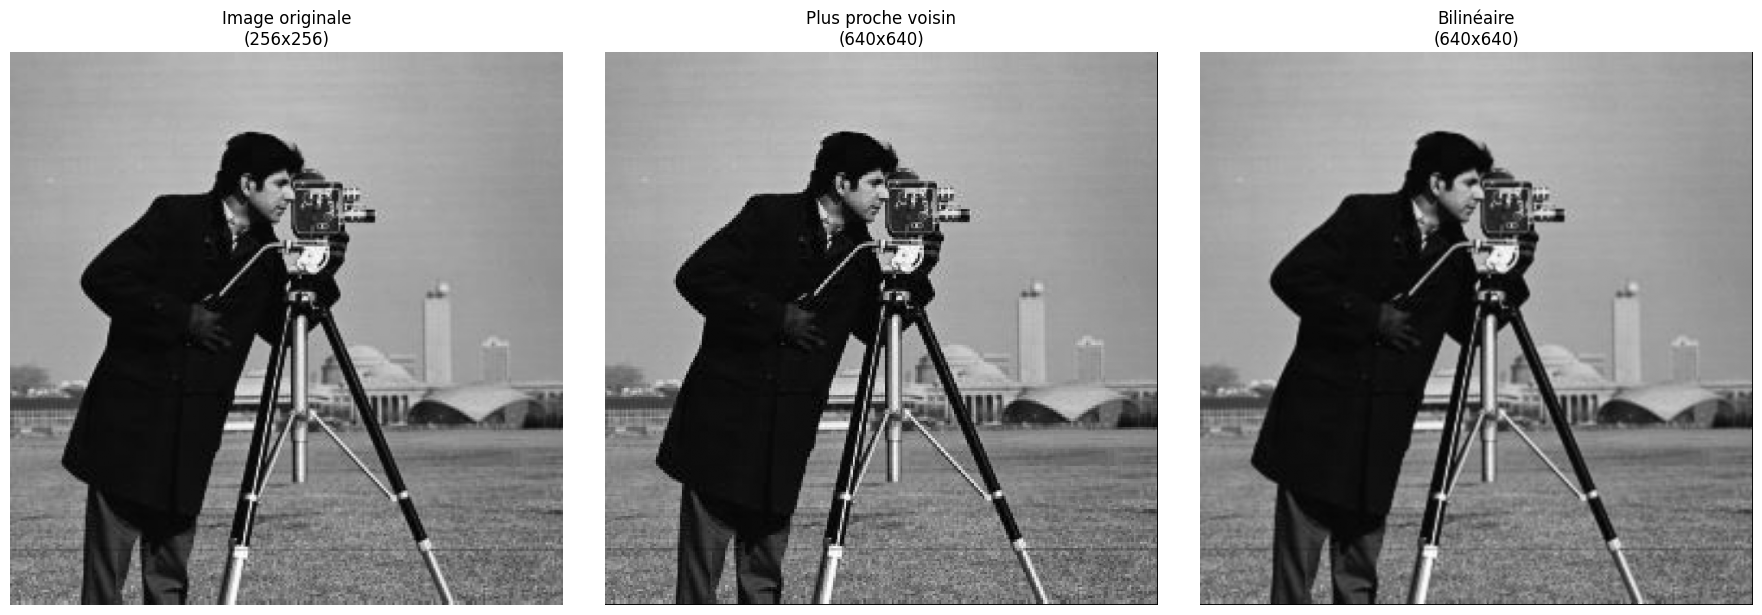

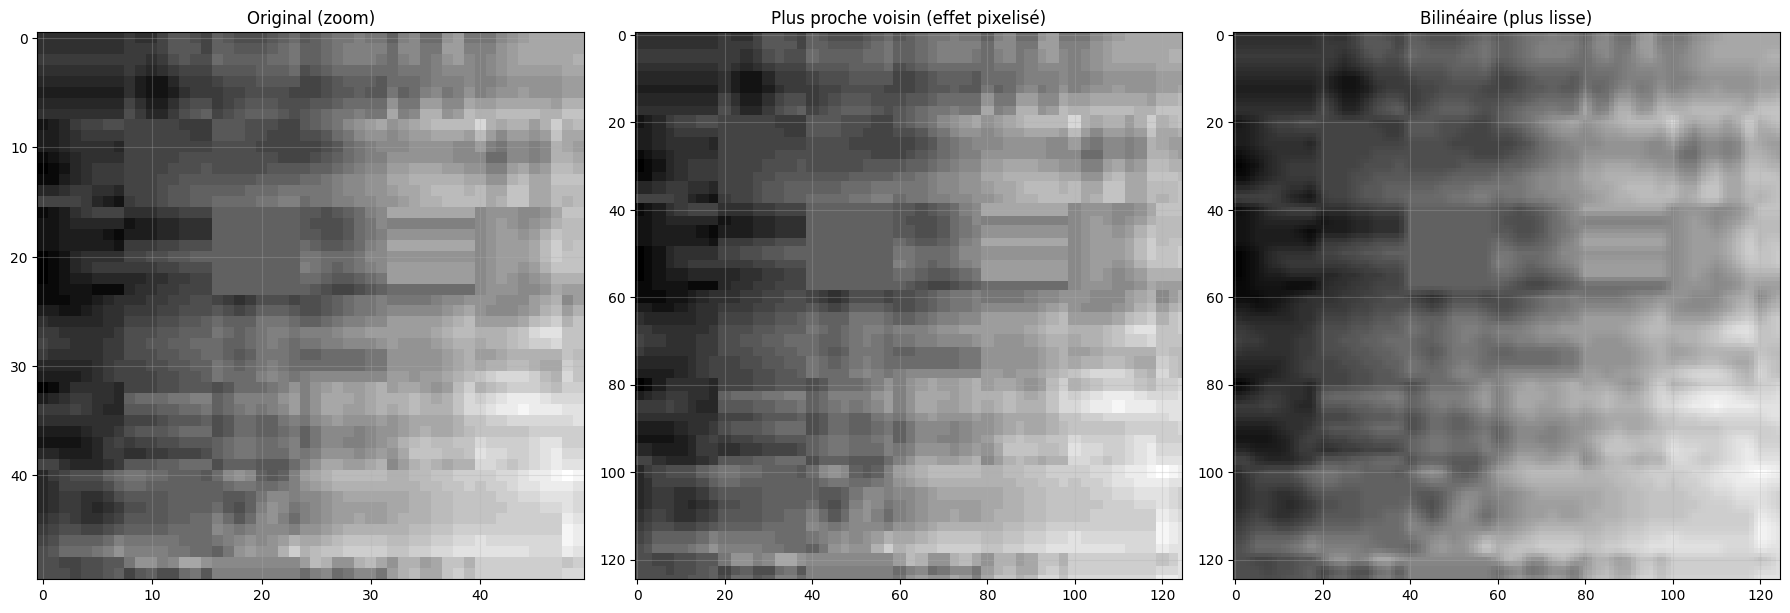


Observation: L'interpolation bilinéaire produit une image plus lisse,
sans les effets de pixelisation visibles avec le plus proche voisin.


In [39]:
# Test de l'agrandissement avec interpolation bilinéaire
factor = 2.5
image_expanded_bilinear = expand(image_test, factor, interpolate_bilinear)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image_test, cmap='gray')
axes[0].set_title(f'Image originale\n({image_test.shape[0]}x{image_test.shape[1]})')
axes[0].axis('off')

axes[1].imshow(image_expanded_nearest, cmap='gray')
axes[1].set_title(f'Plus proche voisin\n({image_expanded_nearest.shape[0]}x{image_expanded_nearest.shape[1]})')
axes[1].axis('off')

axes[2].imshow(image_expanded_bilinear, cmap='gray')
axes[2].set_title(f'Bilinéaire\n({image_expanded_bilinear.shape[0]}x{image_expanded_bilinear.shape[1]})')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Zoom pour comparer les deux méthodes
zoom_size = 50
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image_test[:zoom_size, :zoom_size], cmap='gray', interpolation='nearest')
axes[0].set_title('Original (zoom)')
axes[0].grid(True, alpha=0.3)

zoom_new = int(zoom_size * factor)
axes[1].imshow(image_expanded_nearest[:zoom_new, :zoom_new], cmap='gray', interpolation='nearest')
axes[1].set_title('Plus proche voisin (effet pixelisé)')
axes[1].grid(True, alpha=0.3)

axes[2].imshow(image_expanded_bilinear[:zoom_new, :zoom_new], cmap='gray', interpolation='nearest')
axes[2].set_title('Bilinéaire (plus lisse)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservation: L'interpolation bilinéaire produit une image plus lisse,")
print("sans les effets de pixelisation visibles avec le plus proche voisin.")

## Exercice 4 : Rotation d'image


In [40]:
def rotate(image, angle_degrees, interpolation_func=interpolate_bilinear, expand_canvas=True):

    height, width = image.shape
    angle_rad = np.radians(angle_degrees)

    # Centre de l'image source
    cx_src = width / 2.0
    cy_src = height / 2.0

    if expand_canvas:
        # Calculer la taille du nouveau canvas
        cos_a = abs(np.cos(angle_rad))
        sin_a = abs(np.sin(angle_rad))
        new_width = int(np.ceil(width * cos_a + height * sin_a))
        new_height = int(np.ceil(width * sin_a + height * cos_a))
    else:
        new_width = width
        new_height = height

    result = np.zeros((new_height, new_width), dtype=image.dtype)

    # Centre de l'image de destination
    cx_dst = new_width / 2.0
    cy_dst = new_height / 2.0

    # Matrice de rotation inverse
    cos_theta = np.cos(-angle_rad)  # Rotation inverse
    sin_theta = np.sin(-angle_rad)

    for y_dst in range(new_height):
        for x_dst in range(new_width):
            # Coordonnées relatives au centre de l'image destination
            x_rel = x_dst - cx_dst
            y_rel = y_dst - cy_dst

            # Application de la rotation inverse
            x_src = cos_theta * x_rel - sin_theta * y_rel + cx_src
            y_src = sin_theta * x_rel + cos_theta * y_rel + cy_src

            # Interpolation
            result[y_dst, x_dst] = interpolation_func(image, x_src, y_src)

    return result

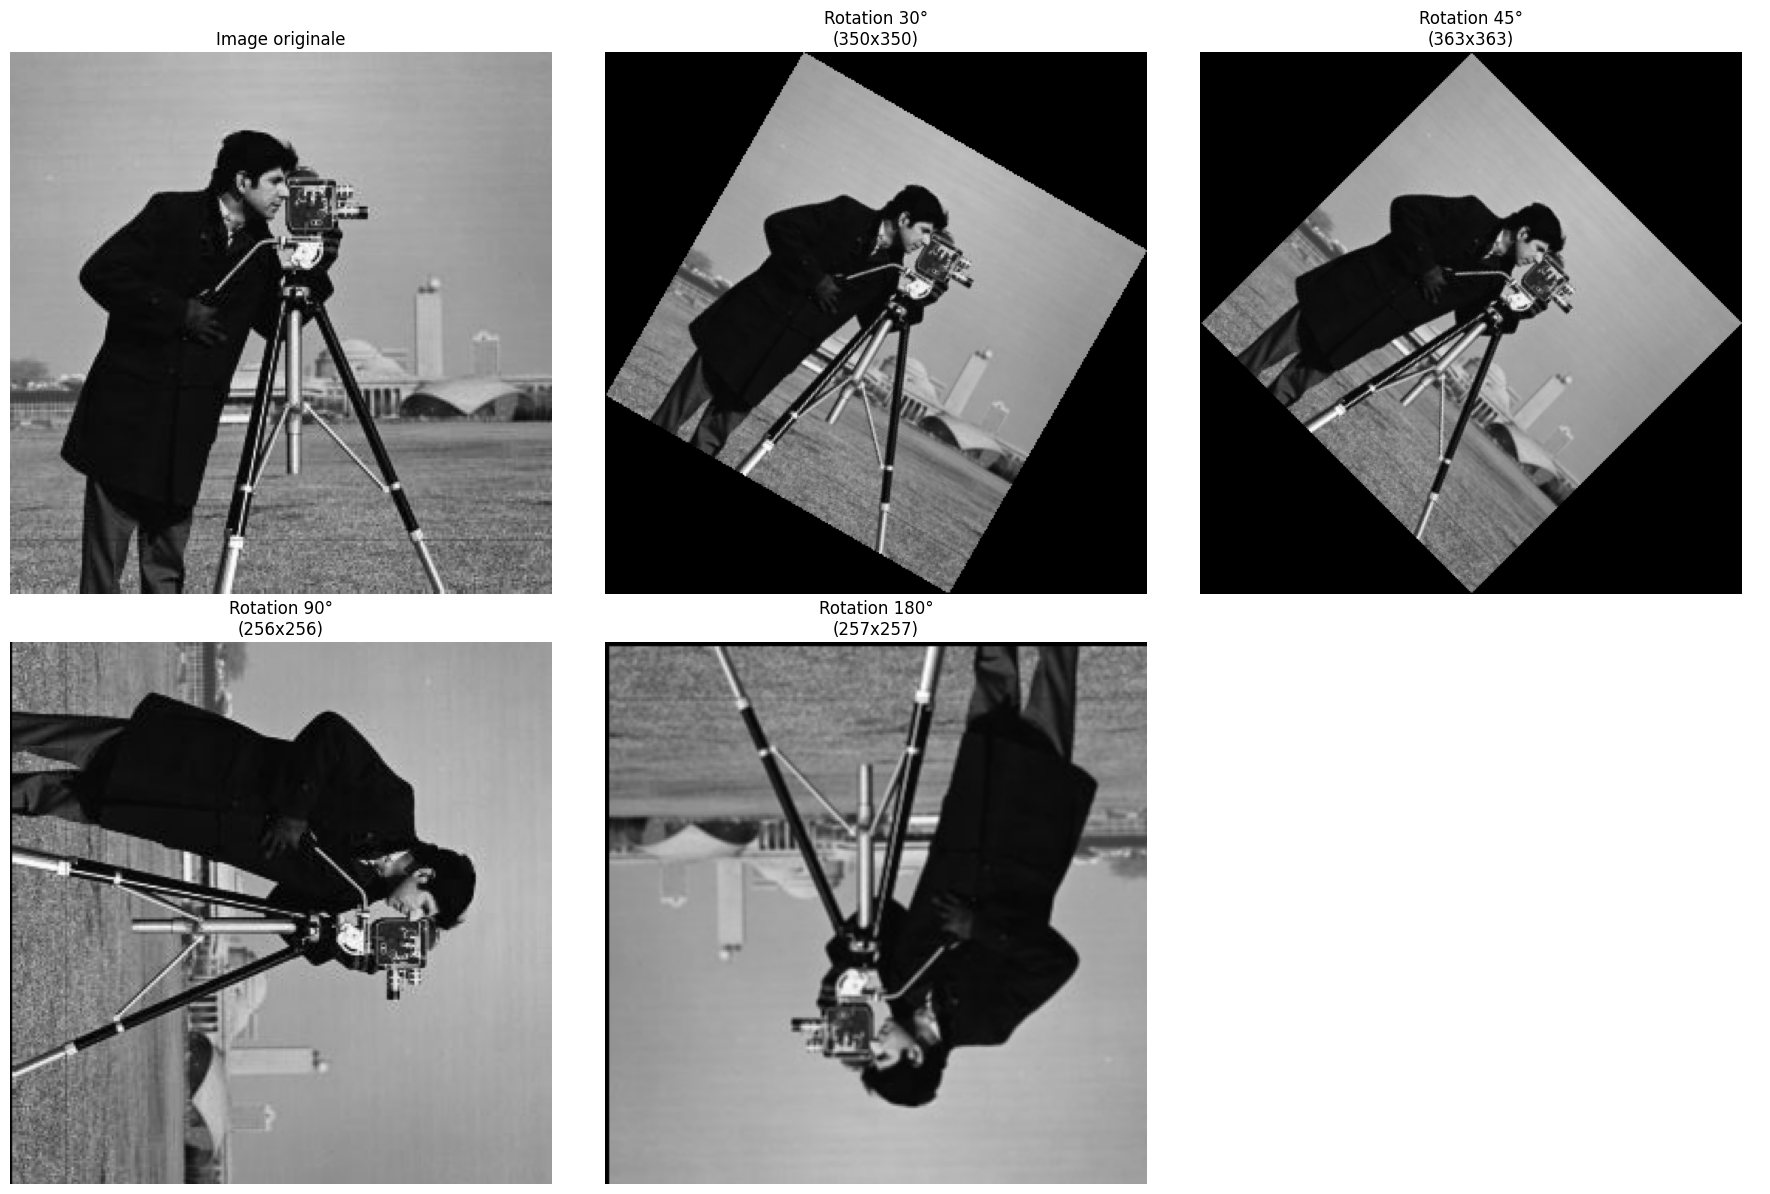

In [41]:
# Test de la rotation avec différents angles
angles = [30, 45, 90, 180]

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

axes[0].imshow(image_test, cmap='gray')
axes[0].set_title('Image originale')
axes[0].axis('off')

for i, angle in enumerate(angles, 1):
    rotated = rotate(image_test, angle, interpolate_bilinear, expand_canvas=True)
    axes[i].imshow(rotated, cmap='gray')
    axes[i].set_title(f'Rotation {angle}°\n({rotated.shape[0]}x{rotated.shape[1]})')
    axes[i].axis('off')

# Enlever le dernier subplot vide
axes[5].axis('off')

plt.tight_layout()
plt.show()

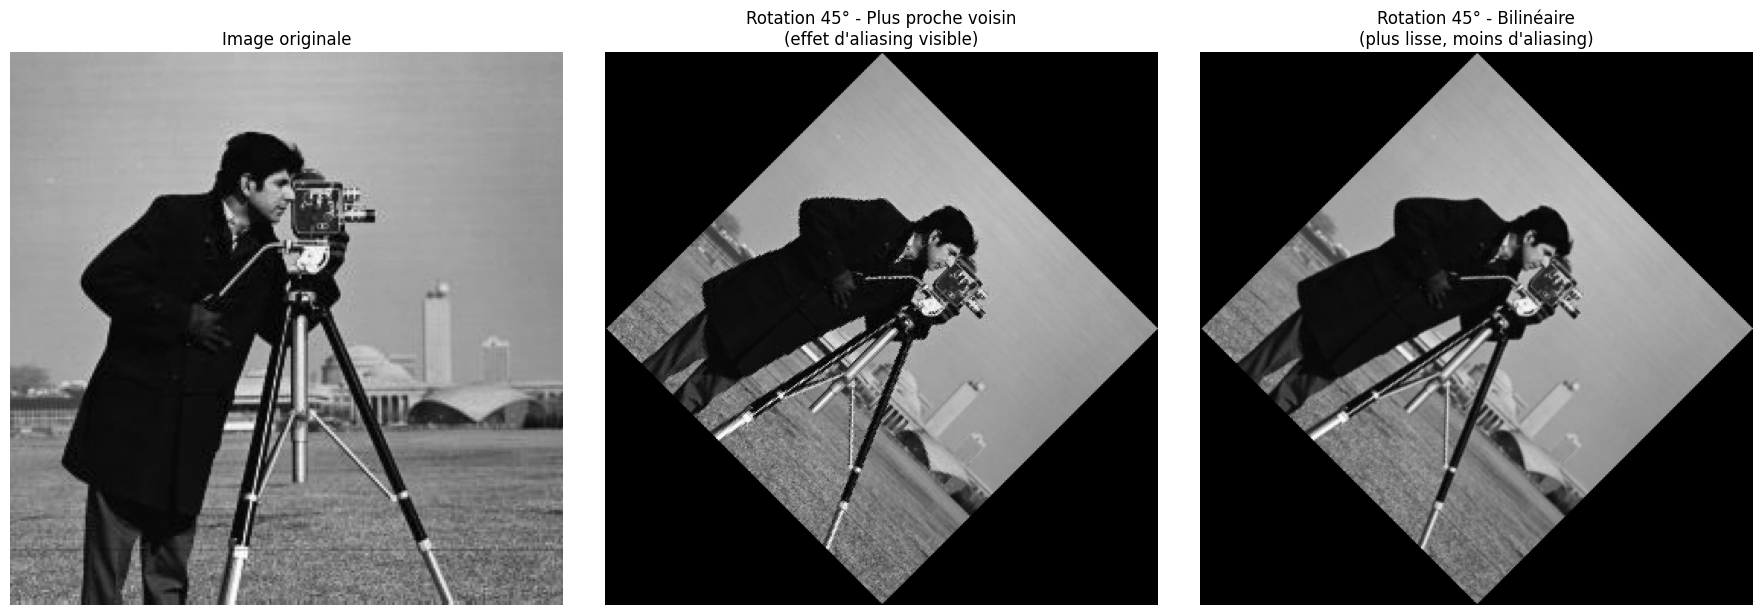

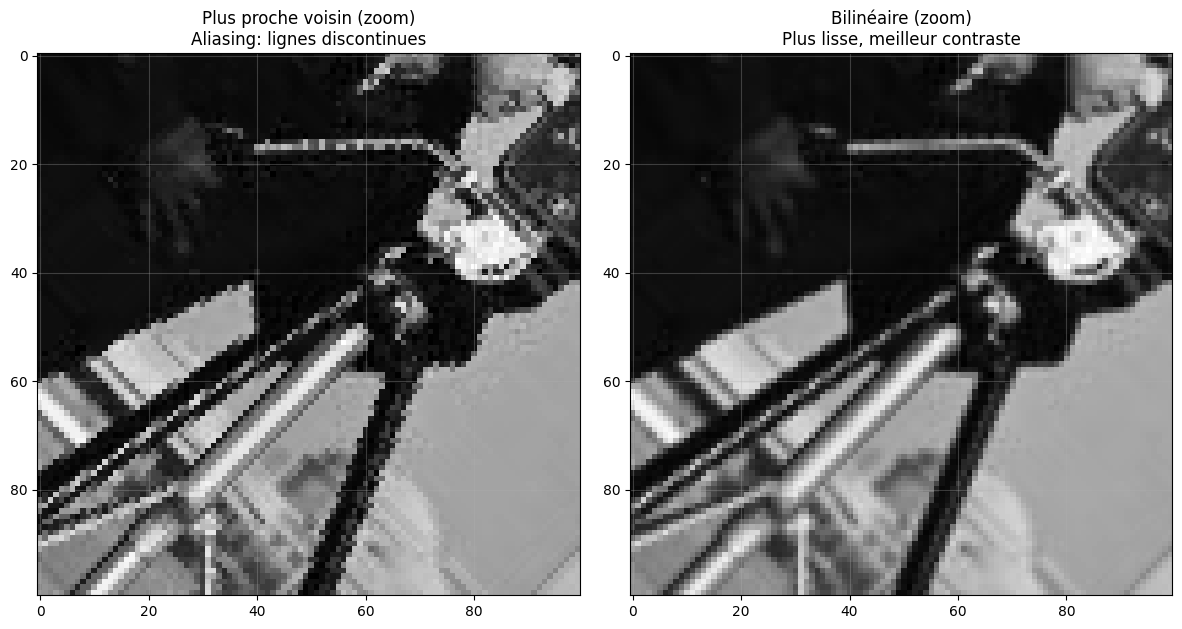

In [42]:
# Comparaison des méthodes d'interpolation pour la rotation
angle = 45

rotated_nearest = rotate(image_test, angle, interpolate_nearest, expand_canvas=True)
rotated_bilinear = rotate(image_test, angle, interpolate_bilinear, expand_canvas=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image_test, cmap='gray')
axes[0].set_title('Image originale')
axes[0].axis('off')

axes[1].imshow(rotated_nearest, cmap='gray')
axes[1].set_title(f'Rotation {angle}° - Plus proche voisin\n(effet d\'aliasing visible)')
axes[1].axis('off')

axes[2].imshow(rotated_bilinear, cmap='gray')
axes[2].set_title(f'Rotation {angle}° - Bilinéaire\n(plus lisse, moins d\'aliasing)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Zoom sur une partie pour voir la différence
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

zoom_h, zoom_w = 100, 100
start_y, start_x = rotated_nearest.shape[0]//2 - zoom_h//2, rotated_nearest.shape[1]//2 - zoom_w//2

axes[0].imshow(rotated_nearest[start_y:start_y+zoom_h, start_x:start_x+zoom_w], cmap='gray', interpolation='nearest')
axes[0].set_title('Plus proche voisin (zoom)\nAliasing: lignes discontinues')
axes[0].grid(True, alpha=0.3)

axes[1].imshow(rotated_bilinear[start_y:start_y+zoom_h, start_x:start_x+zoom_w], cmap='gray', interpolation='nearest')
axes[1].set_title('Bilinéaire (zoom)\nPlus lisse, meilleur contraste')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()